In [1]:
from pathlib import Path
from joblib import Memory
import h5py
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch, find_peaks, ricker, cwt
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

In [2]:
DATA_DIR = Path.cwd() / 'data/' # EMG signals
CACHE_DIR = Path.cwd() / 'cache/' # cache previously done computations (via joblib)

memory = Memory(CACHE_DIR)

## Pre-Processing Functions

The following functions pre-process the surface EMG signals
via digital filters. One filter is a bandpass filter (from 20 Hz to 500 Hz) and the other is a notch filter
at 50 Hz. 

A sampling rate of 2048 Hz is used. 

The code seems to imply a sampling rate of 4 kHz however?

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/ nyq, highcut/ nyq], btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def notch(notch_freq, samp_freq, quality_factor=30):
    b, a = iirnotch(notch_freq, quality_factor, samp_freq)
    return b, a

def notch_filter(data, notch_fs, fs, q=30):
    b, a = notch(notch_fs, fs, q)
    y = filtfilt(b, a, data)
    return y

@memory.cache
def filt_GRID(data, lowcut=20, highcut=500, fs=4000, order=3, notch_fs = 50, notch_q = 30):
    filt_out = np.zeros_like(data)
    for i in range(data.shape[0]):
        filt_out[i,:] = notch_filter(butter_bandpass_filter(data[i,:], lowcut, highcut, fs, order=order), notch_fs, fs, notch_q)
    return filt_out


In [4]:
def loadmat(filename):
    file = h5py.File(filename, 'r')
    return np.asarray(file['grid_crds']), np.asarray(file['out_mat'])

if1_grid_crds, if1_out_mat = loadmat(DATA_DIR / r'increasing-force-1.mat')
if2_grid_crds, if2_out_mat = loadmat(DATA_DIR / r'increasing-force-2.mat')
sf1_grid_crds, sf1_out_mat = loadmat(DATA_DIR / r'steady-force-1.mat')

emg = sf1_out_mat

print(emg.shape)

(73214, 64)


The surface EMG signals, as collected at all the electrodes, are held in the ``emg`` variable.
Each column is a separate electrode, and the rows denote how the signal at that electrode evolves over time.

There are a total of 64 electrodes, arranged like the following:

<div>
<img src="electrodes.png" width="500"/>
</div>


In [5]:
filtered_if1_out_mat = filt_GRID(emg.T).T

In [6]:
def plot_emg(emg, time_bounds=None, channels=[], figsize=None):

    if not channels:
        num_rows = emg.shape[1]
        channels = range(1, emg.shape[1]+1)
    else:
        num_rows = len(channels)

    if figsize is None:
        print(num_rows)
        figsize = [10, (15 * num_rows) // 8]
        print(figsize)

    #if time_bounds is None:
    #    time_bounds = (10000, 10000+1500)

    left, right = time_bounds
    assert 0 <= left <= right

    fig, ax = plt.subplots(nrows=num_rows, figsize=figsize)
    #fig, ax = plt.subplots(nrows=1)

    for i, idx in enumerate(channels):
        curr_ax = ax[i] if len(channels) != 1 else ax # handles singleton case
        curr_ax.plot(emg[:, idx-1])
        curr_ax.set_xlim(left=left, right=right)
        curr_ax.set_ylabel(f"Electrode {idx}")
        #ax.plot(emg[:, i])
        #ax.set_xlim(left=left, right=right)
        #ax.set_ylabel(f"Electrode {i*step_size}")
    
    
    return fig, ax

[8, 16, 24, 32, 40, 48, 56, 64, 7, 15, 23, 31, 39, 47, 55, 63, 6, 14, 22, 30, 38, 46, 54, 62, 5, 13, 21, 29, 37, 45, 53, 61, 4, 12, 20, 28, 36, 44, 52, 60, 3, 11, 19, 27, 35, 43, 51, 59, 2, 10, 18, 26, 34, 42, 50, 58, 1, 9, 17, 25, 33, 41, 49, 57]
64
[10, 120]


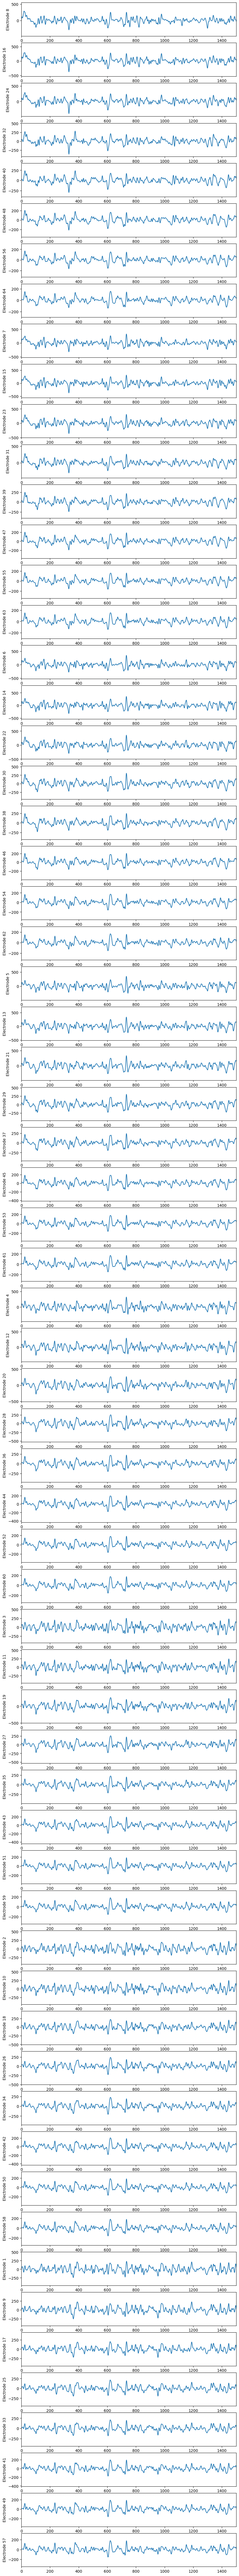

In [7]:
#%matplotlib ipympl
channels = list(np.flipud(np.arange(64).reshape((8,8)).T + 1).ravel())
print(channels)
fig, ax = plot_emg(filtered_if1_out_mat, channels=channels, time_bounds=(0, 1500))
plt.show()


## Source Separation and Firing Time Estimation

Our process for conducting source separation on the EMG signals will be as follows:

1. *STFT.* Typical MUAP pulses have a duration of around 5-15 ms (Electromyography and Neuromuscular Disorders, pages 235-248, 2013, Preston, David C.). Using this fact, we carry out STFT with a window size of 128 samples (512 point FFT), and a hop size which is $\frac{1}{4}$ of the window size (around 32 samples).

Some additional bandpass filtering could be done to amplify the differences between MUAPs (high frequency differences
which become attenuated due to the lowpass nature of tissue that the signals propagate through). Furthermore, it shortens their time support, which reduces the overlap between MUAPs.

2. *Convolutive NMF.* We will pick up on short lived, temporal motifs which hopefully correspond to MUAPs, and use that to segment apart the signal. This makes the assumption that motor units can be identified by a single, unique, characteristic pulse.

In [8]:
# filtered_IC = butter_bandpass_filter(IC.T, lowcut=50, highcut=150, fs=4000).T

# fig, ax = plt.subplots(nrows=filtered_IC.shape[1]//8, figsize=[10, 10])
# for i in range(0, filtered_IC.shape[1]//8):
#     ax[i].plot(filtered_IC[:, i])
#     ax[i].set_xlim(left=10000, right=10000+1500)
# plt.show()

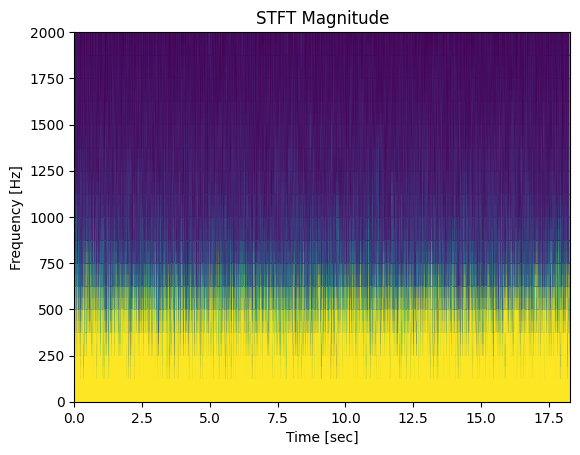

In [117]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

rng = np.random.default_rng()
fs = 4000
N = 1e5
time = np.arange(N) / float(fs)

channel = 8 # channel can be 1, 2, 3, ... , 64

#f, t, Zxx = signal.stft(emg[:, channel-1], fs, nperseg=128, nfft=512, noverlap=int(0.75 * 128))
#candidate = butter_bandpass_filter(emg[:, channel-1].T, lowcut=500, highcut=1000, fs=4000).T
f, t, Zxx = signal.stft(candidate, fs, nperseg=nperseg, nfft=nfft)

candidate = emg[:, channel-1]
nperseg = 32
nfft = 32
mag_stft = np.abs(Zxx)

mag_stft = mag_stft / (2.0 ** -52 + mag_stft.sum())

plt.pcolormesh(t, f, mag_stft, vmin=0, vmax=np.quantile(mag_stft, 0.75), shading='gouraud')

plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [121]:
from NMFtoolbox import NMFD

numComp = 10
numTemplateFrames = 2
initW = np.random.uniform(0, np.quantile(mag_stft, 0.75), size=(numComp, Zxx.shape[0], numTemplateFrames))
initH = np.random.uniform(0, np.quantile(mag_stft, 0.75), size=(numComp, Zxx.shape[1]))

In [122]:
initW.shape
initH.shape

(10, 4577)

In [123]:
W, H, nmfdV, costFunc, tensorW = NMFD.NMFD(mag_stft, parameter={'numComp': numComp, 'numIter': 4000, 'numTemplateFrames': numTemplateFrames, 'initW': initW, 'initH': initH})

Processing:   0%|          | 0/4000 [00:00<?, ?it/s]

The ``nmfdV`` are all the modulated versions of the building block spectrograms (the $W$ matrix). In other terms, they are a collection of outer products formed using the building blocks and weights.

As a sanity check, we will make sure that the sum of the outer products yields a spectrogram that resembles the original ``Zxx``.

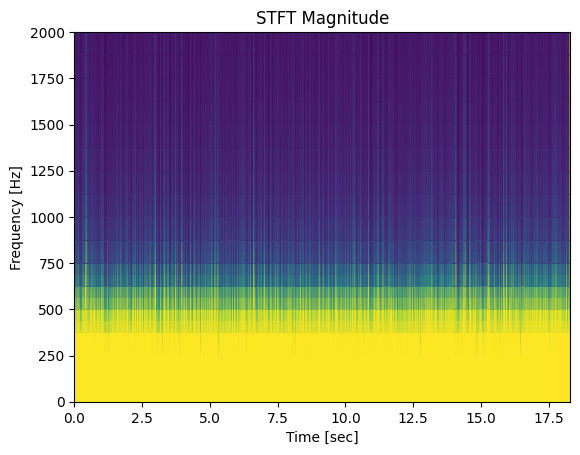

In [124]:
plt.pcolormesh(t, f, np.sum(nmfdV, axis=0), vmin=0, vmax=np.quantile(mag_stft, 0.75), shading='gouraud')

plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

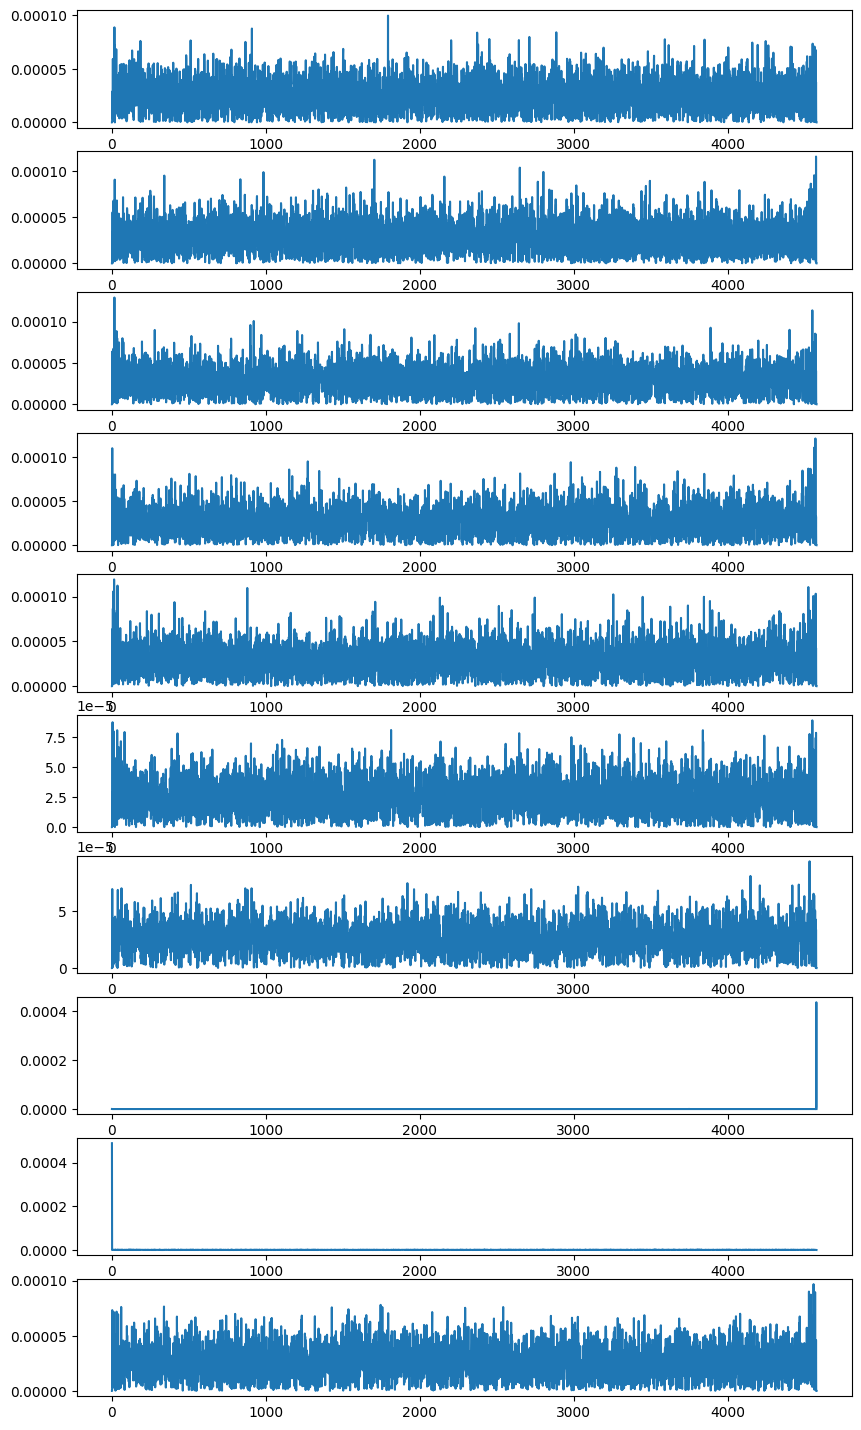

In [125]:
nmf_idx = 10

#plt.figure()
#plt.plot(H[nmf_idx])
#plt.show()

fig, ax = plt.subplots(nrows=H.shape[0], figsize=[10, (15 * H.shape[0]) // 8])

for i, v in enumerate(H):
    ax[i].plot(v)

plt.show()

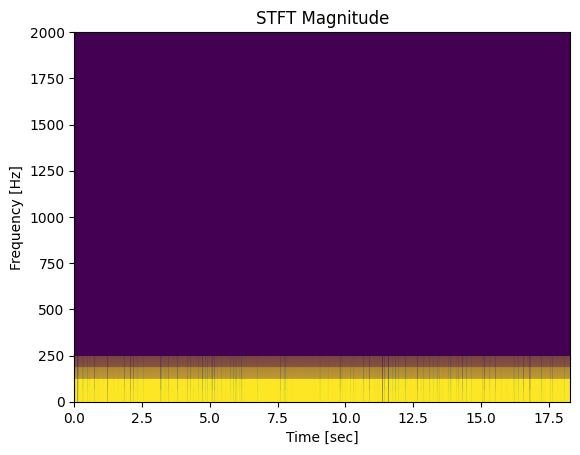

In [116]:
nmf_idx = 4
nmf_comp = nmfdV[nmf_idx]
plt.pcolormesh(t, f, nmf_comp, vmin=0, vmax=np.quantile(mag_stft, 0.75), shading='gouraud')

plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()